## imports

In [ ]:
%matplotlib inline

In [ ]:
import sys
import os
sys.path.append("../")
import copy

In [ ]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "fairness-variance":
    os.chdir("../..")

print('Current location: ', os.getcwd())

In [ ]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from aif360.algorithms.preprocessing.lfr import LFR

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from virny.preprocessing import preprocess_dataset
from source.preprocessing import get_simple_preprocessor

from notebooks.mult_repair_levels_student_performance.StudentPerformanceDataset import StudentPerformanceDataset

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import matplotlib.pyplot as plt


## dataset loading

In [ ]:
class Config:
    file_name = './data/student_performance/student-mat.csv'
    Az_EXPERIMENT_PARAMETERS_LIST = ...
    Ax_EXPERIMENT_PARAMETERS_LIST = ...
    Ay_EXPERIMENT_PARAMETERS_LIST = ...
    BINS_SIZE = 10
    Az_DEFAULT_VALUE = 50.0
    Ax_DEFAULT_VALUE = ...
    Ay_DEFAULT_VALUE = ...
    sensitive_attribute = 'sex_binary'

In [ ]:
np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1)

In [ ]:
data_loader = StudentPerformanceDataset(Config.file_name)
data_loader.X_data.head()

## dataset processing

In [ ]:
init_data_loader = copy.deepcopy(data_loader)

In [ ]:
data_loader.categorical_columns = [col for col in data_loader.categorical_columns if
                                   col not in ('sex')]
data_loader.X_data['sex_binary'] = data_loader.X_data['sex'].apply(lambda x: 1 if x == 'M' else 0)
data_loader.full_df = data_loader.full_df.drop(['sex'], axis=1)
data_loader.X_data = data_loader.X_data.drop(['sex'], axis=1)

column_transformer = get_simple_preprocessor(data_loader)
base_flow_dataset = preprocess_dataset(data_loader, column_transformer, 0.3, 42)
base_flow_dataset.init_features_df = init_data_loader.full_df.drop(init_data_loader.target, axis=1,
                                                                   errors='ignore')
base_flow_dataset.X_train_val['sex_binary'] = data_loader.X_data.loc[
    base_flow_dataset.X_train_val.index, 'sex_binary']
base_flow_dataset.X_test['sex_binary'] = data_loader.X_data.loc[base_flow_dataset.X_test.index, 'sex_binary']

## compute basic metrics

In [ ]:
dataset_orig_train, dataset_orig_test = train_test_split(data_loader.X_data, test_size=0.3)

In [ ]:
train_df = base_flow_dataset.X_train_val
train_df[base_flow_dataset.target] = base_flow_dataset.y_train_val

test_df = base_flow_dataset.X_test
test_df[base_flow_dataset.target] = base_flow_dataset.y_test

In [ ]:
train_binary_dataset = BinaryLabelDataset(df=train_df,
                                              label_names=[data_loader.target],
                                              protected_attribute_names=[Config.sensitive_attribute],
                                              favorable_label=1,
                                              unfavorable_label=0)
test_binary_dataset = BinaryLabelDataset(df=test_df,
                                         label_names=[data_loader.target],
                                         protected_attribute_names=[Config.sensitive_attribute],
                                         favorable_label=1,
                                         unfavorable_label=0)

In [ ]:
privileged_groups = [{'sex_binary': 1}]
unprivileged_groups = [{'sex_binary': 0}]

metric_orig_train = BinaryLabelDatasetMetric(train_binary_dataset,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(test_binary_dataset,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

In [ ]:
TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         Az=50.0,
         verbose=1
        )
TR = TR.fit(train_binary_dataset)

In [ ]:
dataset_transf_train = TR.transform(train_binary_dataset)
dataset_transf_test = TR.transform(test_binary_dataset)

In [ ]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())

In [ ]:
train_df, _ = train_binary_dataset.convert_to_dataframe()
test_df, _ = test_binary_dataset.convert_to_dataframe()

In [ ]:
train_df.head(10)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

In [ ]:
train_X = train_df.drop(['G3'], axis=1)
train_y = train_df['G3']

In [ ]:
test_X = test_df.drop(['G3'], axis=1)
test_y = test_df['G3']

In [ ]:
rfc = rfc.fit(train_X, train_y)

In [ ]:
y_pred = rfc.predict(test_X)

In [ ]:
report = classification_report(test_y, y_pred)
print("Classification Report:\n", report)

In [ ]:
train_df, _ = dataset_transf_train.convert_to_dataframe()
test_df, _ = dataset_transf_test.convert_to_dataframe()

rfc = RandomForestClassifier(random_state=42)

train_X = train_df.drop(['G3'], axis=1)
train_y = train_df['G3']

test_X = test_df.drop(['G3'], axis=1)
test_y = test_df['G3']

rfc = rfc.fit(train_X, train_y)

y_pred = rfc.predict(test_X)

report = classification_report(test_y, y_pred)
print("Classification Report:\n", report)

## Tune parameters for LFR

### Az parameter tuning

In [45]:
def calculate_false_negative_rate_difference(train_bin_dset, test_bindset, y_true, y_pred, params):
    test_binary_dataset_pred = test_bindset.copy()
    test_binary_dataset_pred.labels = y_pred

    metric = ClassificationMetric(
        test_bindset, test_binary_dataset_pred,
        unprivileged_groups=params["unprivileged_groups"],
        privileged_groups=params["privileged_groups"]
    )

    return metric.false_negative_rate()

In [46]:
def calculate_false_positive_rate_difference(train_bin_dset, test_bindset, y_true, y_pred, params):
    test_binary_dataset_pred = test_bindset.copy()
    test_binary_dataset_pred.labels = y_pred

    metric = ClassificationMetric(
        test_bindset, test_binary_dataset_pred,
        unprivileged_groups=params["unprivileged_groups"],
        privileged_groups=params["privileged_groups"]
    )

    return metric.false_positive_rate()

In [30]:
def calculate_opportunity_difference(train_bin_dset, test_bindset, y_true, y_pred, params):
    test_binary_dataset_pred = test_bindset.copy()
    test_binary_dataset_pred.labels = y_pred

    metric = ClassificationMetric(
        test_bindset, test_binary_dataset_pred,
        unprivileged_groups=params["unprivileged_groups"],
        privileged_groups=params["privileged_groups"]
    )

    return metric.equal_opportunity_difference()

In [31]:
def calculate_disparate_impact(train_bin_dset, test_bindset, y_true, y_pred, params):
    test_binary_dataset_pred = test_bindset.copy()
    test_binary_dataset_pred.labels = y_pred

    metric = ClassificationMetric(
        test_bindset, test_binary_dataset_pred,
        unprivileged_groups=params["unprivileged_groups"],
        privileged_groups=params["privileged_groups"]
    )

    return metric.disparate_impact()

In [47]:
def calculate_metrics(train_binary_dataset, test_binary_dataset, y_true, y_pred, params):
    metric = params["metric"]

    if metric == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric == 'classification_report':
        return classification_report(y_true, y_pred)
    elif metric == 'disparate_impact':
        return calculate_disparate_impact(train_binary_dataset, test_binary_dataset, y_true, y_pred, params)
    elif metric == 'equal_opportunity_difference':
        return calculate_opportunity_difference(train_binary_dataset, test_binary_dataset, y_true, y_pred, params)
    elif metric == 'false_positive_rate_difference':
        return calculate_false_positive_rate_difference(train_binary_dataset, test_binary_dataset, y_true, y_pred, params)
    elif metric == 'false_negative_rate_difference':
        return calculate_false_negative_rate_difference(train_binary_dataset, test_binary_dataset, y_true, y_pred, params)

    raise ValueError(f"Unsupported metric: {metric}")

In [33]:
def run_experiment(az_parameters, Ax, Ay, train_binary_dataset, test_binary_dataset, params):
    metric_results = []

    for az in az_parameters:
        if az == 0:
            train_df, _ = train_binary_dataset.convert_to_dataframe()
            test_df, _ = test_binary_dataset.convert_to_dataframe()
        else:
            TR = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups,
                     Ax=Ax, Ay=Ay, Az=az)
            TR = TR.fit(train_binary_dataset)

            dataset_transf_train = TR.transform(train_binary_dataset)
            dataset_transf_test = TR.transform(test_binary_dataset)

            train_df, _ = dataset_transf_train.convert_to_dataframe()
            test_df, _ = dataset_transf_test.convert_to_dataframe()

        rfc = RandomForestClassifier(random_state=42)

        train_X = train_df.drop(['G3'], axis=1)
        train_y = train_df['G3']

        test_X = test_df.drop(['G3'], axis=1)
        test_y = test_df['G3']

        rfc = rfc.fit(train_X, train_y)

        y_pred = rfc.predict(test_X)

        metric_value = calculate_metrics(train_binary_dataset, test_binary_dataset, test_y, y_pred, params)
        metric_results.append(metric_value)

    return metric_results

In [39]:
def run_and_plot_experiment(params):

    Az_VALUES = params["Az_VALUES"]
    Ax_VALUES = params["Ax_VALUES"]
    Ay_VALUES = params["Ay_VALUES"]
    metric = params["metric"]

    param_combinations = list(product(Ax_VALUES, Ay_VALUES))

    fig, axes = plt.subplots(len(Ax_VALUES), len(Ay_VALUES), figsize=(16, 12))
    fig.suptitle(f"{metric} vs. Az & Ax & Ay")

    for i, values in enumerate(param_combinations):
        Ax, Ay = values[0], values[1]

        metric_values = run_experiment(Az_VALUES, Ax, Ay, train_binary_dataset, test_binary_dataset, params)

        row_index = i // len(Ay_VALUES)
        col_index = i % len(Ay_VALUES)

        ax = axes[row_index, col_index]
        ax.plot(Az_VALUES, metric_values, marker='o', label=f'Ax={Ax}, Ay={Ay}')
        ax.set_title(f"Ax={Ax}, Ay={Ay}")
        ax.set_xlabel("Az Parameter")
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

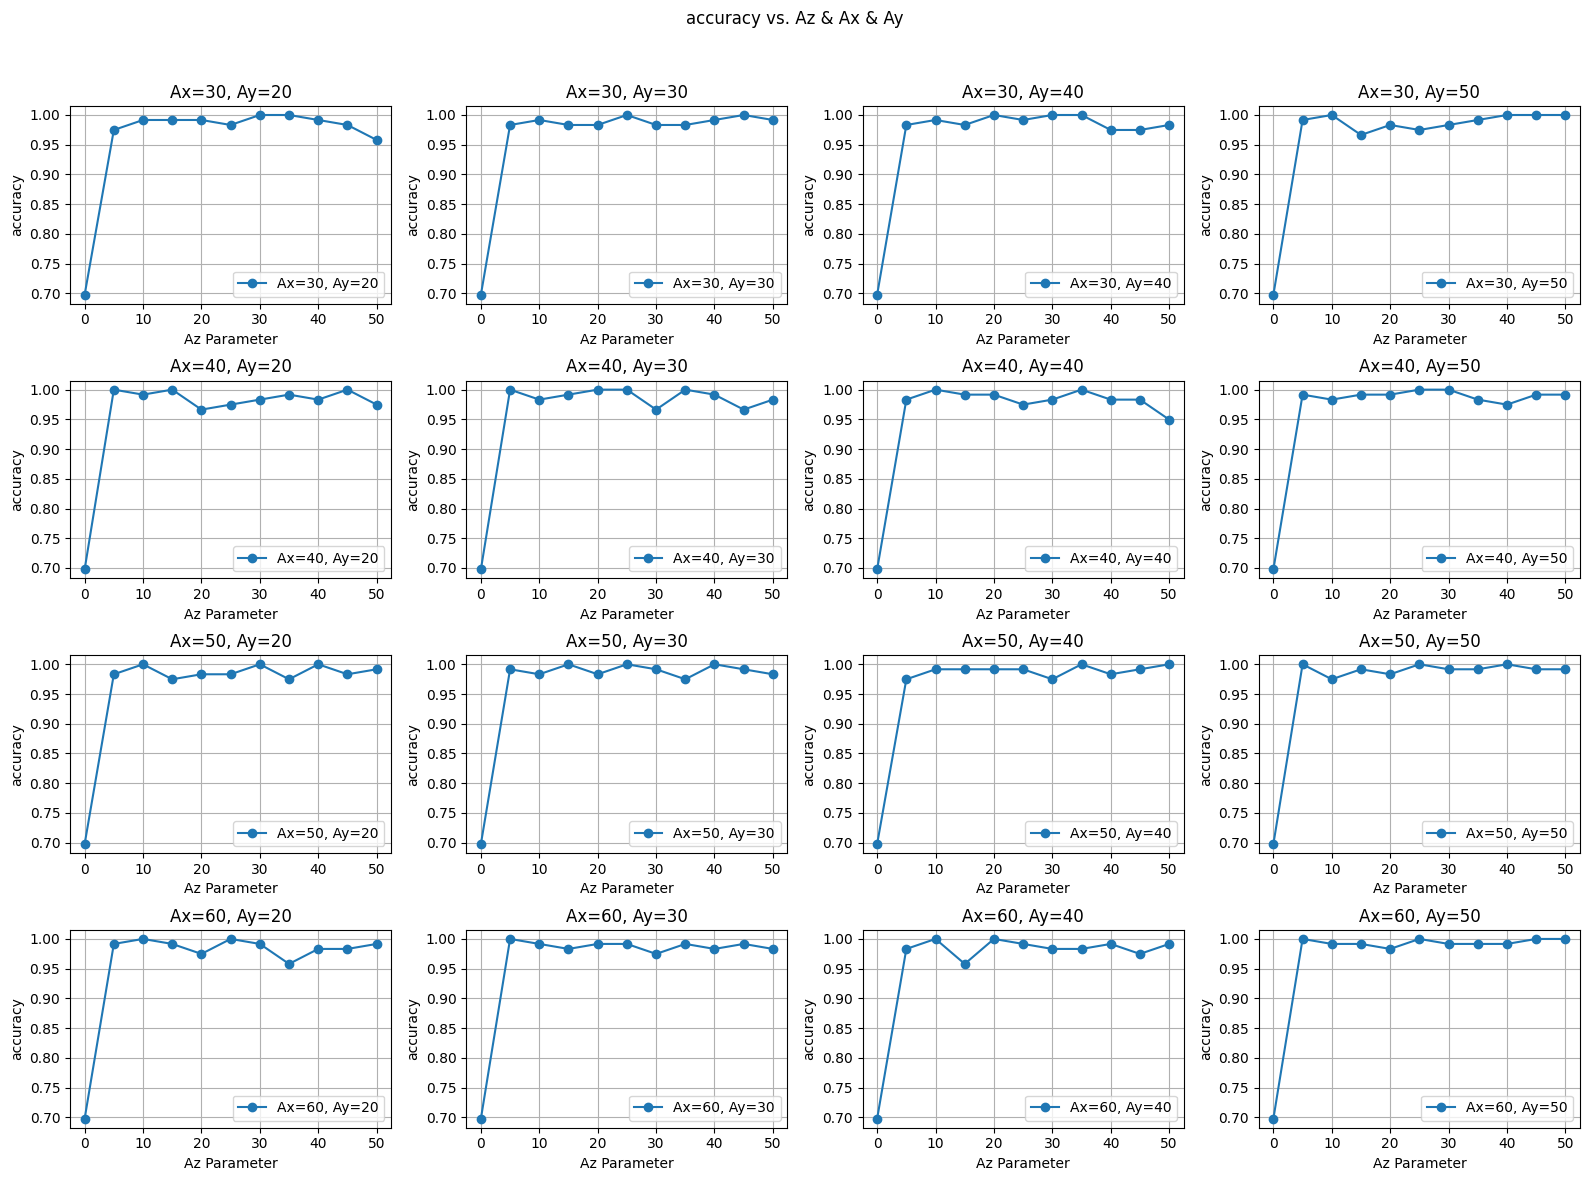

In [40]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [30, 40, 50, 60],
    "Ay_VALUES": [20, 30, 40, 50],
    "metric": "accuracy"
}

run_and_plot_experiment(params)

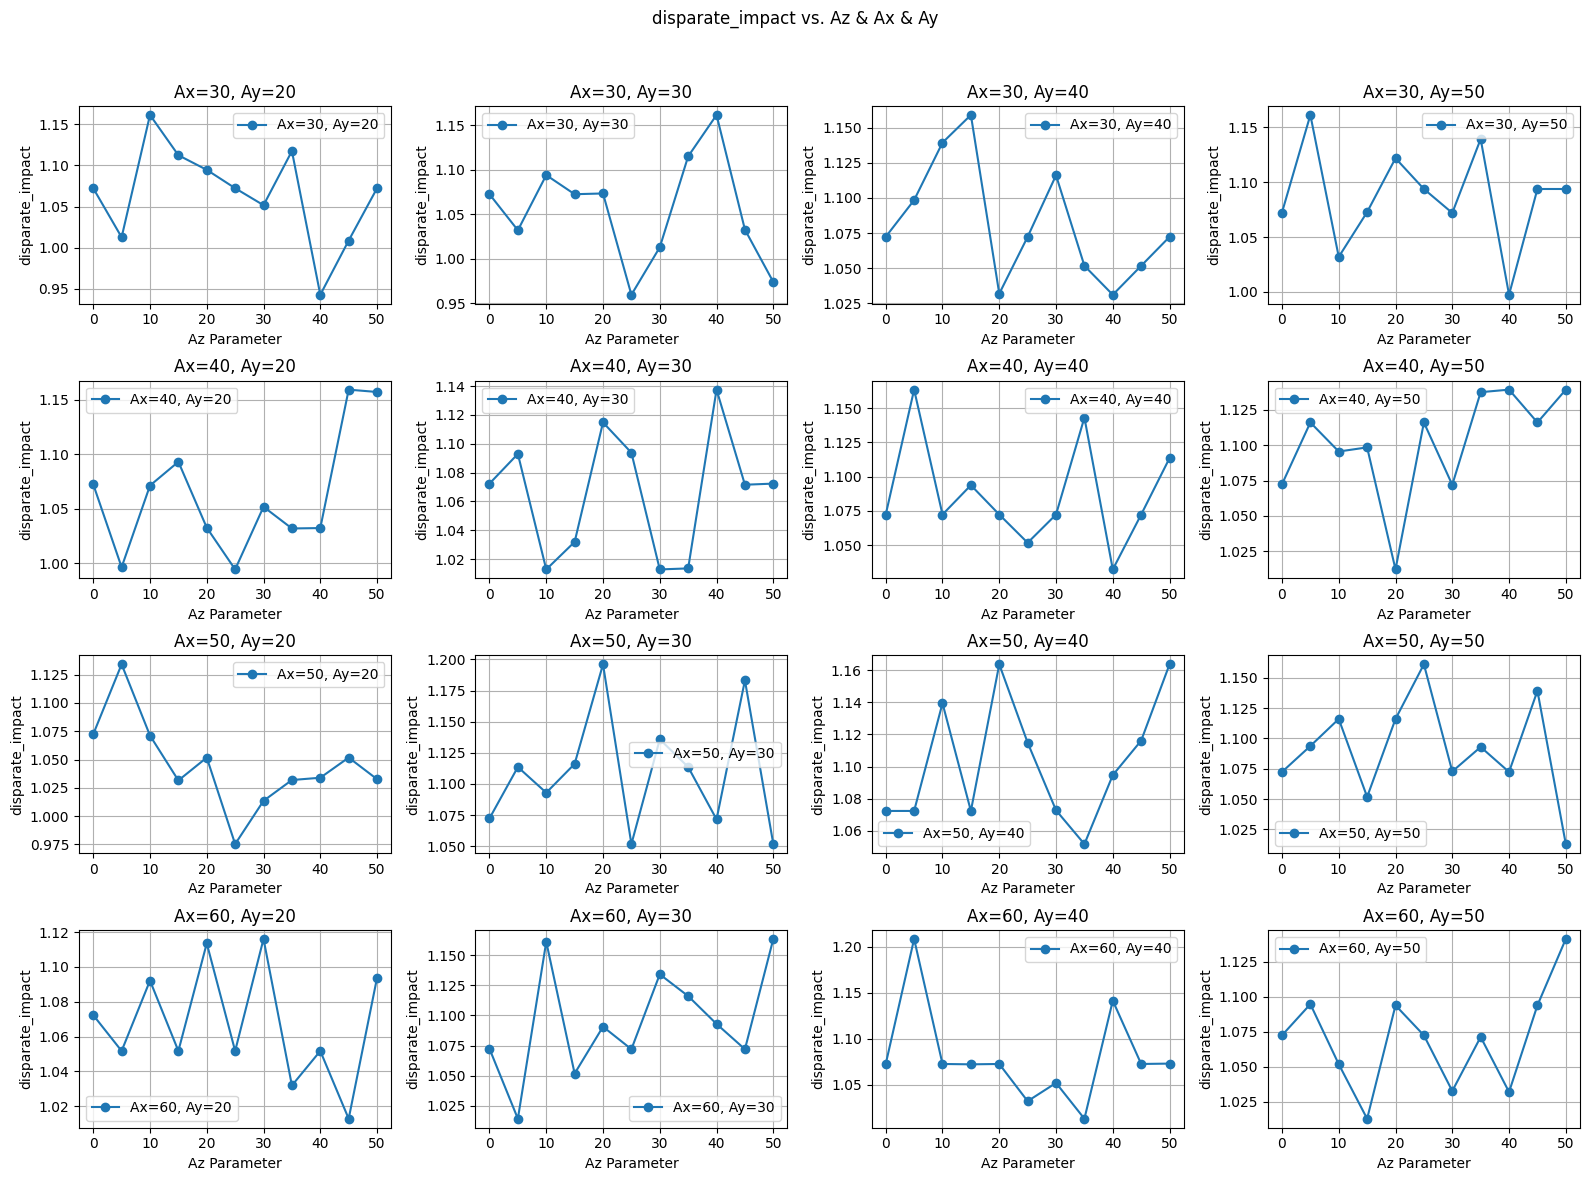

In [41]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [30, 40, 50, 60],
    "Ay_VALUES": [20, 30, 40, 50],
    "metric": "disparate_impact",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

run_and_plot_experiment(params)

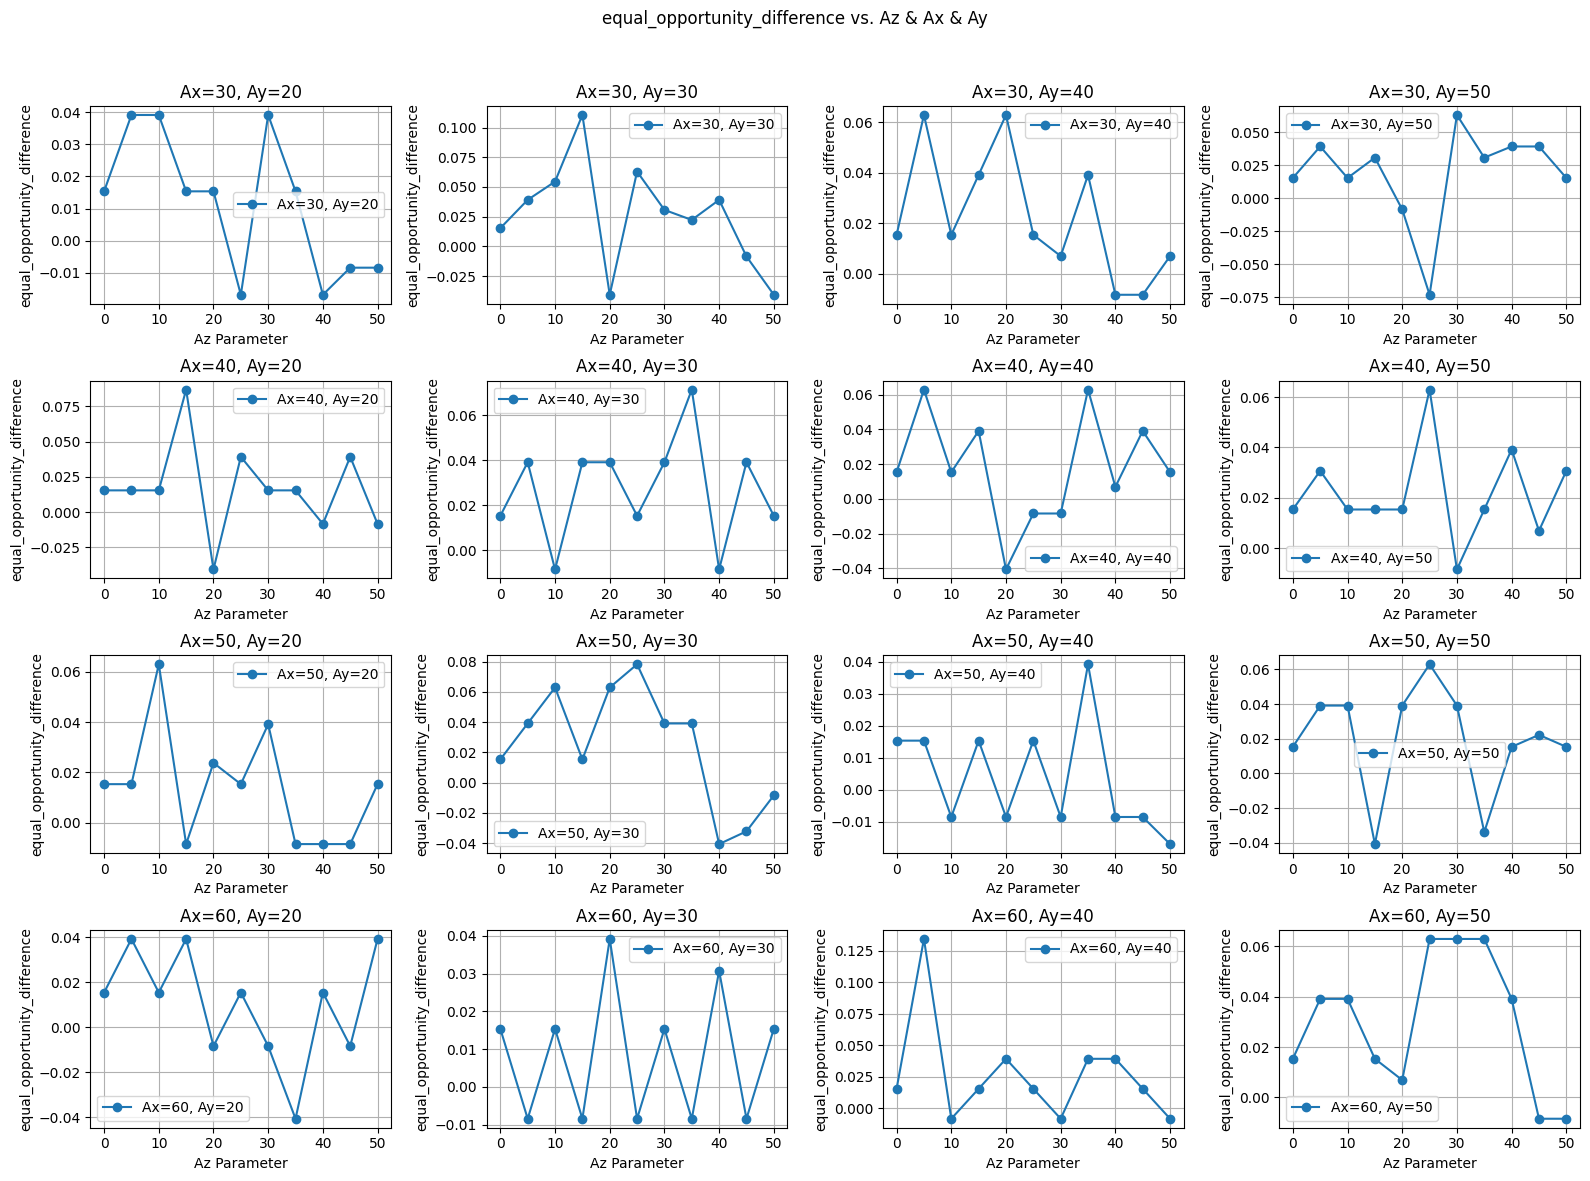

In [44]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [30, 40, 50, 60],
    "Ay_VALUES": [20, 30, 40, 50],
    "metric": "equal_opportunity_difference",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

run_and_plot_experiment(params)

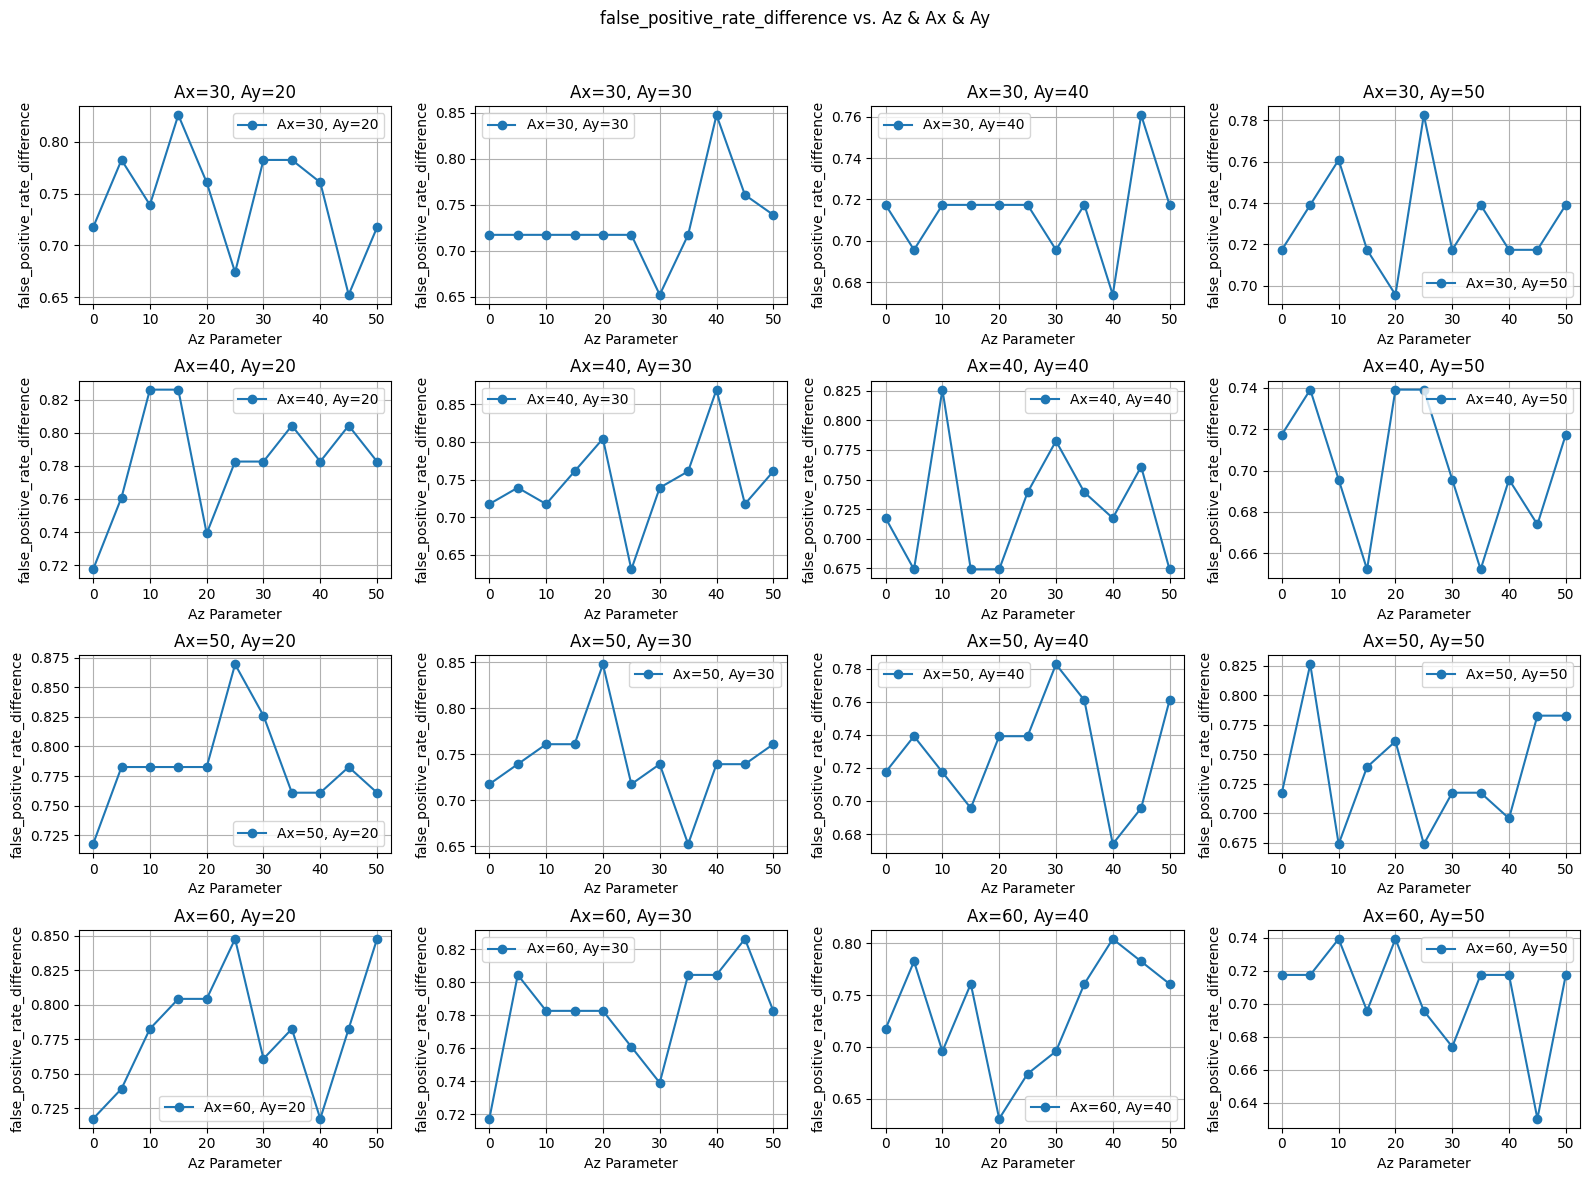

In [48]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [30, 40, 50, 60],
    "Ay_VALUES": [20, 30, 40, 50],
    "metric": "false_positive_rate_difference",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

run_and_plot_experiment(params)

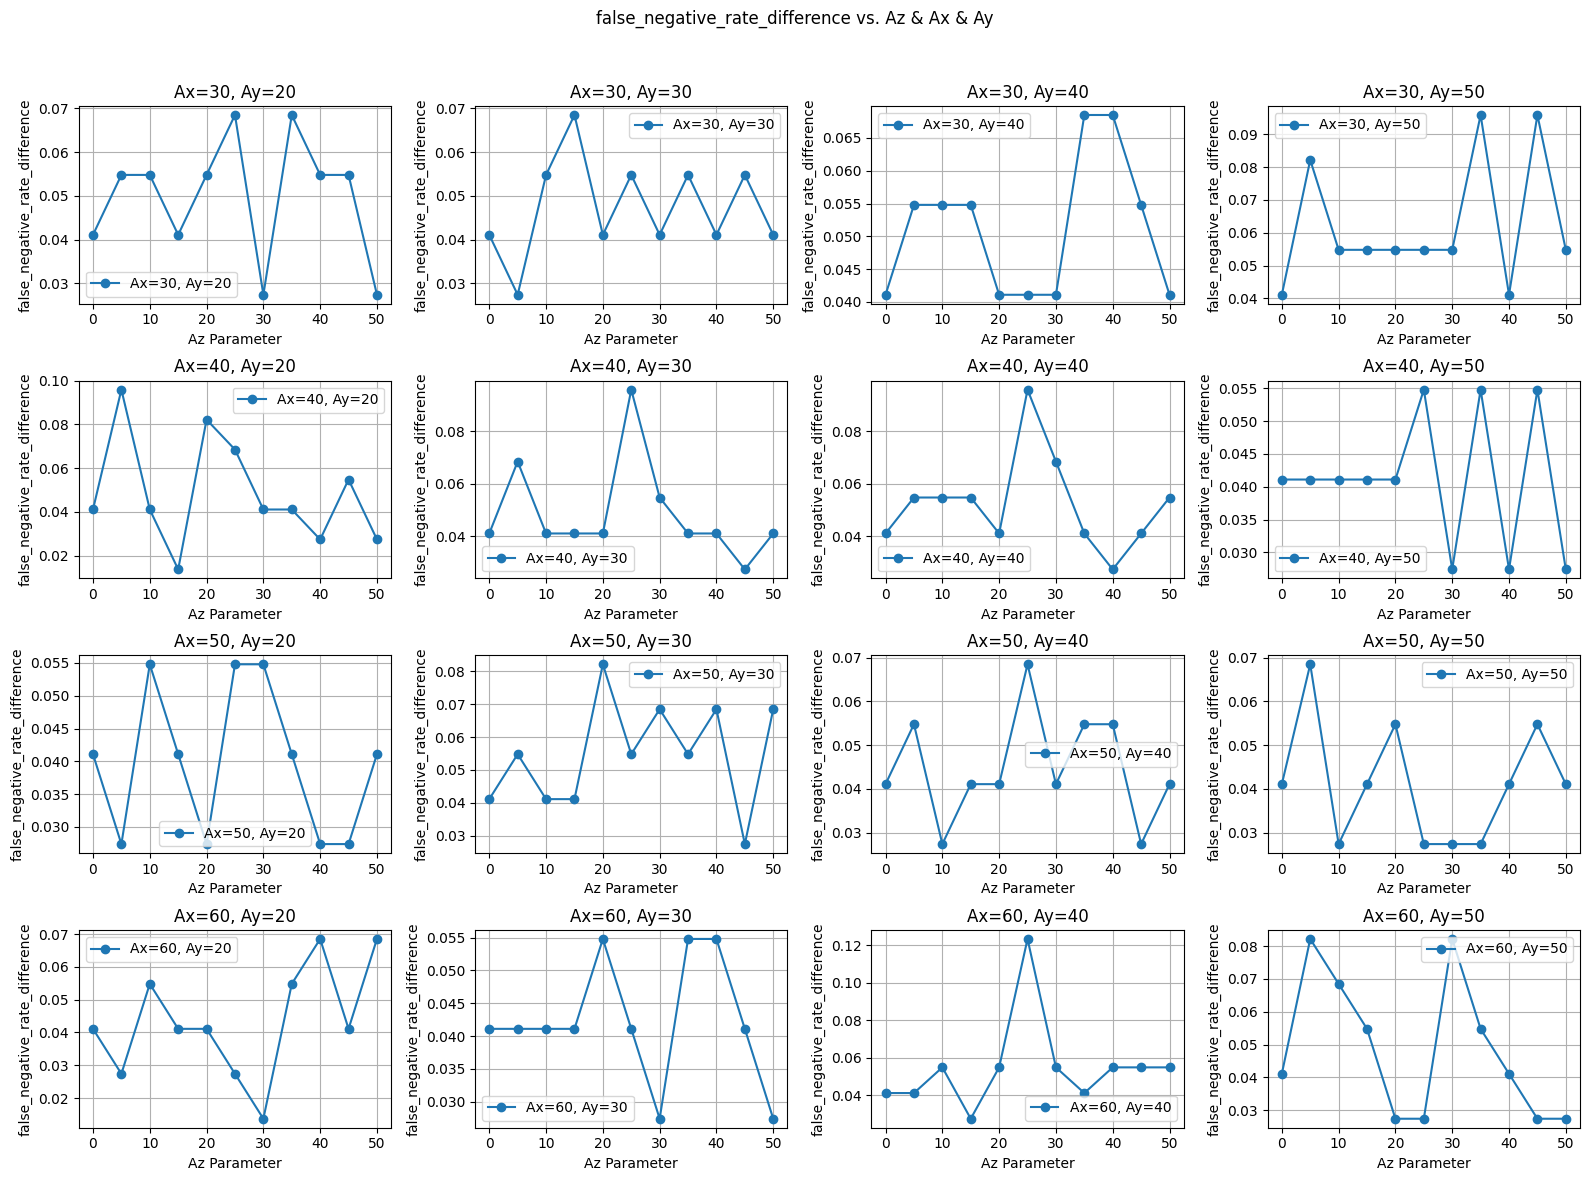

In [49]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [30, 40, 50, 60],
    "Ay_VALUES": [20, 30, 40, 50],
    "metric": "false_negative_rate_difference",
    "unprivileged_groups": unprivileged_groups,
    "privileged_groups": privileged_groups
}

run_and_plot_experiment(params)

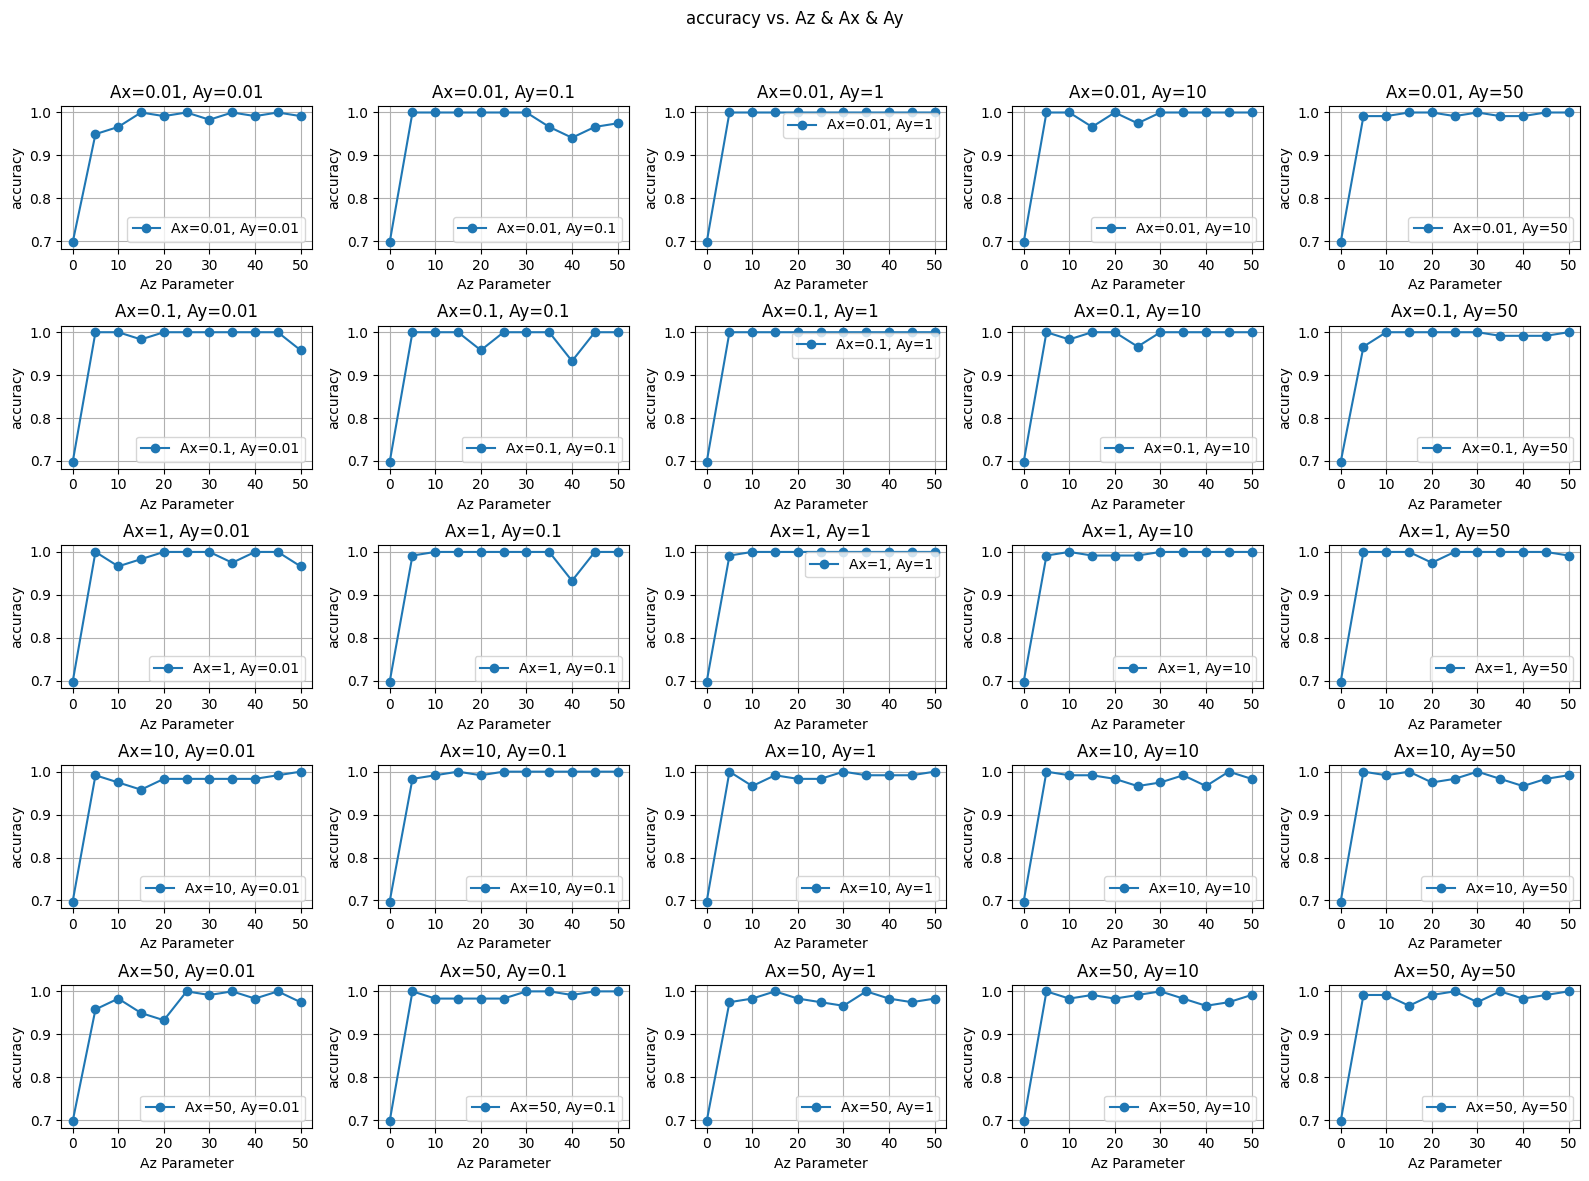

In [50]:
params = {
    "Az_VALUES": np.linspace(0, Config.Az_DEFAULT_VALUE, Config.BINS_SIZE + 1),
    "Ax_VALUES": [0.01, 0.1, 1, 10, 50],
    "Ay_VALUES": [0.01, 0.1, 1, 10, 50],
    "metric": "accuracy"
}

run_and_plot_experiment(params)



# run experiment Ax=10, Ay=0.01, Az=Az (with that)

## test

In [ ]:
import pandas as pd

def test_between_group():
    data = np.array([[0, 0, 1],
                     [0, 1, 0],
                     [1, 1, 0],
                     [1, 1, 1],
                     [1, 0, 0],
                     [1, 0, 0]])
    pred = data.copy()
    pred[[0, 3], -1] = 0
    pred[[4, 5], -1] = 1
    print(pred)
    print(data)
    df = pd.DataFrame(data, columns=['feat', 'feat2', 'label'])
    df2 = pd.DataFrame(pred, columns=['feat', 'feat2', 'label'])
    bld = BinaryLabelDataset(df=df, label_names=['label'],
        protected_attribute_names=['feat', 'feat2'])
    bld2 = BinaryLabelDataset(df=df2, label_names=['label'],
        protected_attribute_names=['feat', 'feat2'])
    cm = ClassificationMetric(bld, bld2, unprivileged_groups=[{'feat': 0}],
        privileged_groups=[{'feat': 1}])

    b = np.array([0.5, 0.5, 1.25, 1.25, 1.25, 1.25])
    assert cm.between_group_generalized_entropy_index() == 1/12*np.sum(b**2 - 1)

In [ ]:
test_between_group()